# Benchmarks

Timings reported in paper

In [1]:
# %env http_proxy=http://proxyserv:3128
# %env https_proxy=http://proxyserv:3128

In [2]:
%load_ext rpy2.ipython

from IPython.display import Image
from graphviz import Digraph
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('ticks')
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

In [3]:
%%R
# install.packages("matrixdist")
# install.packages("expm")

NULL


In [4]:
%%R
# remove.packages("PhaseTypeR")
# install.packages("PhaseTypeR")

NULL


In [5]:
%%R
#remove.packages("PhaseTypeR")
#devtools::install_github("kaspermunch/PhaseTypeR")

NULL


In [6]:
%%R
devtools::install_github("TobiasRoikjer/PtDAlgorithms")
library(ptdalgorithms)

set.seed(7)

R[write to console]: Skipping install of 'ptdalgorithms' from a github remote, the SHA1 (29809aeb) has not changed since last install.
  Use `force = TRUE` to force installation



In [7]:
%%R
library(ptdalgorithms)
library(PhaseTypeR)
library(matrixdist)
library(expm)
# library(ggplot2)

R[write to console]: Indlæser krævet pakke: expm

R[write to console]: Indlæser krævet pakke: Matrix

R[write to console]: 
Vedhæfter pakke: ‘expm’


R[write to console]: Det følgende objekt er maskeret fra ‘package:Matrix’:

    expm


R[write to console]: Indlæser krævet pakke: matrixdist

R[write to console]: Indlæser krævet pakke: igraph

R[write to console]: 
Vedhæfter pakke: ‘igraph’


R[write to console]: De følgende objekter er maskerede fra ‘package:ptdalgorithms’:

    edges, vertices


R[write to console]: De følgende objekter er maskerede fra ‘package:stats’:

    decompose, spectrum


R[write to console]: Det følgende objekt er maskeret fra ‘package:base’:

    union


R[write to console]: 
Vedhæfter pakke: ‘PhaseTypeR’


R[write to console]: Det følgende objekt er maskeret fra ‘package:Matrix’:

    mean


R[write to console]: Det følgende objekt er maskeret fra ‘package:stats’:

    var


R[write to console]: Det følgende objekt er maskeret fra ‘package:base’:

    mean


# Parameters

In [8]:
#%run benchmarks_rabbits_params.ipy
%run benchmarks_kingman_params.ipy
# %run benchmarks_coxian_params.ipy

In [9]:
%%R
niter <- 50

Function for plotting running times:

In [12]:
def runtime_plot(plot_df, x_labels, y_label, hue_label, 
                 colors=['#FF0000', '#2901F7', '#05BFC0'], 
                 legend=True, legend_title=True):
    
    # with sns.color_palette(colors):
    with sns.color_palette("Set1"):
        gs_kw = dict(height_ratios=[50] + [1]*(len(x_labels)-1))
        fig, axes = plt.subplots(len(x_labels), 1, 
                                 figsize=(5, 5), 
                                 gridspec_kw=gs_kw)

        sns.scatterplot(data=plot_df, x=x_labels[0], y=y_label, hue=hue_label, legend=False, ax=axes[0])    
        ax = sns.lineplot(data=plot_df, x=x_labels[0], y='seconds', hue=hue_label, ax=axes[0])
        # ax.set_yscale('log')

        if not legend_title:
            legend = axes[0].legend()
            legend.set_title("")
        
        leg = ax.get_legend()
        leg.get_frame().set_linewidth(0.0)
        
        if not legend:
            axes[0].get_legend().remove()

        sns.despine()

        for i in range(1, len(x_labels)):
            ax = sns.scatterplot(data=plot_df, x=x_labels[i], y=y_label, hue=hue_label, legend=False, ax=axes[i], alpha=0) 
            axes[i].get_yaxis().set_visible(False)
        plt.tight_layout()
    return fig, axes

Function for parallel computing:

In [11]:
%%R 

library(parallel)

# cores = 4L
cores = 1L

#cores = strtoi(Sys.getenv("SLURM_CPUS_PER_TASK"))
print(cores)
# # producing a matrix
# apply_grid <- function(fun, a, b) {
#     named_params <- expand.grid(a, b)
#     param_list <- split(named_params, seq(nrow(named_params)))    
#     result_list <- mclapply(param_list, function(x) do.call(fun, as.list(as.vector(unlist(x)))), mc.cores=cores)
#     mat <- array(unlist(result_list), dim = c(2, length(a),length(b)))
#     return(mat)
# }
# fun <- function(i, var) {    
#     return(c(i, var))
# }

# producing a dataframe
apply_grid <- function(fun, a, b) {
    named_params <- expand.grid(a, b)
    param_list <- split(named_params, seq(nrow(named_params)))    
    result_list <- mclapply(param_list, function(x) do.call(fun, as.list(as.vector(unlist(x)))), mc.cores=cores)
    return(do.call(rbind, result_list))
}

# # serial version with lapply 
# apply_grid <- function(fun, a, b) {
#     named_params <- expand.grid(a, b)
#     param_list <- split(named_params, seq(nrow(named_params)))    
#     result_list <- lapply(param_list, function(x) do.call(fun, as.list(as.vector(unlist(x)))))
#     return(do.call(rbind, result_list))
# }


# fun <- function(i, var) {    
#     return(as.data.frame(cbind(k=i, munch=var)))
# }


[1] 1


# Construction time

## Construction functions

### Rabbits

Compile function for constructing rabbit model in C:

In [12]:
%%R
Rcpp::sourceCpp("rabbit_construction.cpp")

ld: warning: -pie being ignored. It is only used when linking a main executable


R version:

In [13]:
%%R
construct_rabbit_graph_R <- function(number_of_rabbits, flooding_rate_l, flooding_rate_r) {
    # We represent the vector as two integers, the number of rabbits on the left and right island
    state_vector_length <- 2
    graph <- create_graph(state_vector_length)
    initial_state <- c(number_of_rabbits, 0)
    # The initial state is the only starting state, with 100% starting probability
    add_edge(
      starting_vertex(graph),
      find_or_create_vertex(graph, initial_state),
      1
    )
    index <- 2
    # Iterate over all unvisited vertices
    while (index <= vertices_length(graph)) {
      vertex <- vertex_at(graph, index)
      state <- vertex$state
      if (state[1] > 0) {
        # Rabbit jump left to right
        child_state <- c(state[1] - 1, state[2] + 1)
        add_edge(
          vertex,
          find_or_create_vertex(graph, child_state),
          1
        )

        # Left island flooding
        child_state <- c(0, state[2])
        add_edge(
          vertex,
          find_or_create_vertex(graph, child_state),
          flooding_rate_l
        )
      }

      if (state[2] > 0) {
        # Rabbit jump right to left
        child_state <- c(state[1] + 1, state[2] - 1)
        add_edge(
          vertex,
          find_or_create_vertex(graph, child_state),
          1
        )
        # Right island flooding with rate of 4
        child_state <- c(state[1], 0)
        add_edge(
          vertex,
          find_or_create_vertex(graph, child_state),
          flooding_rate_r
        )
      }
      index <- index + 1
    }
    return(graph)
}


### Kingman

Compile function for constructing the coalescent in C:

In [14]:
%%R
Rcpp::sourceCpp("kingman.cpp")

ld: warning: -pie being ignored. It is only used when linking a main executable


R version:

In [15]:
%%R 
generate_kingman_graph_R <- function(n) {
  
    state_vector_length <- n
    graph <- create_graph(state_vector_length)
    starting_vertex <- vertex_at(graph, 1)
    initial_state <- rep(0, n)
    initial_state[1] <- n

    add_edge(
      starting_vertex,
      create_vertex(graph, initial_state),
      1
    )
    index <- 2

    while (index <= vertices_length(graph)) {
      vertex <- vertex_at(graph, index)

      # loop over all classes of lineages
      for (i in 1:n) {
        for (j in i:n) {
          state <- vertex$state

          # if same class, there need to be at least two to coalesce
          if (i == j) {
            if (state[i] < 2) {
              next;
            }
            # coal rate
            rate <- state[i] * (state[i] - 1) / 2
          } else {
            # else at least one in each class to coalesce
            if (state[i] < 1 || state[j] < 1) {
              next;
            }
            # number of combinations
            rate <- state[i] * state[j]
          }

          # copy state
          child_state <- state
          # update child state
          child_state[i] <- child_state[i] - 1
          child_state[j] <- child_state[j] - 1
          child_state[i+j] <- child_state[i+j] + 1

          add_edge(
              vertex,
              find_or_create_vertex(graph, child_state),
              rate, c(rate)
            )
        }
      }

      index <- index + 1
    }

    return(graph)
}

## Time construction

In [89]:
%%time
%%R -o construction_df
construction_times_fun <- function(i, val) {
    time_R <- NA
    if (val <= max_construction_values_for_R) {
        start <- proc.time()[3]            
        construction_fun_R(val)
        end <- proc.time()[3]
        time_R <- end-start
    } 

    start <- proc.time()[3]
    graph <- construction_fun(val)
    end <- proc.time()[3]
    time_c = end-start

    time_from_matrix <- NA
    if (val <= max_construction_values_for_matrix) {
        M <- graph_as_matrix(graph)
        start <- proc.time()[3]
        mat <- matrix_as_graph(M$IPV, M$SIM)
        end <- proc.time()[3]
        time_from_matrix = end-start
    }
    df <- as.data.frame(cbind(val=val, 
                          time_R=time_R, 
                          time_c=time_c,
                          time_from_matrix=time_from_matrix,
                          vertices=vertices_length(graph), 
                          edges=number_of_edges(graph)))
    return(df)
}
construction_df <- apply_grid(construction_times_fun, 1:(niter*2), construction_values)

CPU times: user 17min 58s, sys: 1min 16s, total: 19min 14s
Wall time: 19min 37s


In [90]:
construction_df.to_hdf(f'benchmark_data/construction_df_{str(label[0])}.hdf', 'df')

Single example with large number of units:

In [18]:
# %%time
# %%R
# # graph <- construction_fun(500)
# graph <- construction_fun(20)

# Time computation

In [19]:
# %%R
# # # graph <- construction_fun(500)
# graph <- construction_fun(200)

In [20]:
# %%time
# %%R
# ptdalgorithms::expectation(graph)

In [21]:
# %%R
# M <- graph_as_matrix(graph)
# Y <- PhaseTypeR::PH(M$SIM, M$IPV)            
# system.time(PhaseTypeR::mean(Y))

In [22]:
# %%R
# graph <- construction_fun(30)
# M <- graph_as_matrix(graph)
# system.time(matrix_as_graph(M$IPV, M$SIM))


## Compare base::solve() against matrixdist:::matrix_inverse()

In [23]:
%%time
%%R -o base_times -o matrixdist_times
base_times <- c()
matrixdist_times <- c()
for (val in expectation_construction_values) {
    if (val <= expectation_max_construction_values_for_matrix/2) {
        graph <- construction_fun(val)
        mat <- graph_as_matrix(graph)$SIM
        base_times <- c(base_times, system.time(MI1 <- base::solve(mat))[3])
        matrixdist_times <- c(matrixdist_times, system.time(MI2 <- matrixdist:::matrix_inverse(mat))[3])
    }
}

CPU times: user 26.5 s, sys: 20.6 s, total: 47 s
Wall time: 51.7 s


In [24]:
np.save(f'benchmark_data/base_times_{str(label[0])}.npy', base_times)
np.save(f'benchmark_data/matrixdist_times_{str(label[0])}.npy', matrixdist_times)

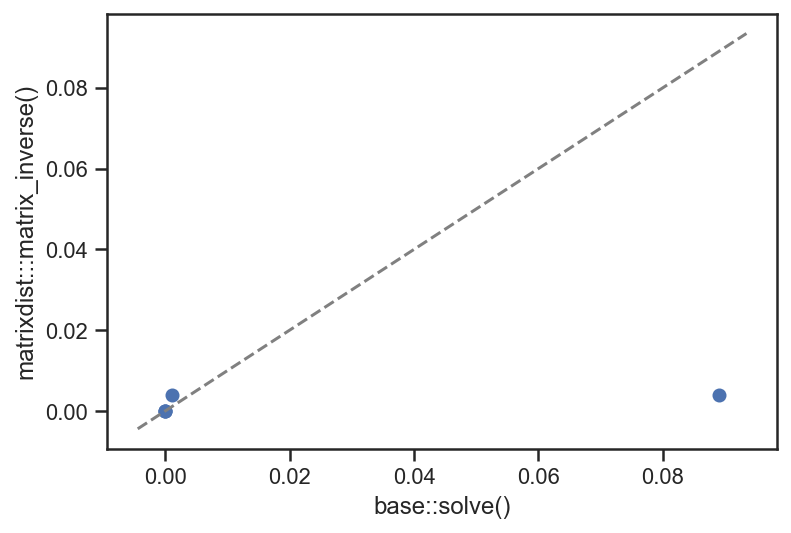

In [25]:
def abline(slope, intercept, ax=None):
    "Add a straight line through the plot"
    if ax is None:
        ax = plt.gca()
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, '--', color='grey')
    
plt.scatter(base_times, matrixdist_times)
plt.xlabel('base::solve()')
plt.ylabel('matrixdist:::matrix_inverse()')
abline(1, 0)
plt.savefig(f'figures/inversion_test_{str(label[0])}.pdf')   

## Test methods for exponentiation with expm()

In [26]:
%%time
%%R -o expm_tests_all_methods

results <- data.frame()
for (i in 1:niter) {
    for (val in expectation_construction_values){
        if (val <= expectation_max_construction_values_for_matrix/2) {
            for (method in c("Higham08.b", "Higham08", "AlMohy-Hi09", "Ward77", "PadeRBS", 
                             # "Pade", "PadeO", "TaylorO", .. the slowest ones
                             # "R_Eigen",   ... does not work with rabbits
                             "Taylor", "R_Pade", "R_Ward77", "hybrid_Eigen_Ward")) {

                graph <- construction_fun(val)
                mat <- graph_as_matrix(graph)$SIM
                start <- proc.time()[3]
                expm::expm(mat, method=method)
                stop <- proc.time()[3]
                time_spent_exp <- stop - start

                results <- rbind(results, data.frame(val=val,
                                                     vertices=vertices_length(graph),
                                                     edges=number_of_edges(graph),
                                                     time_spent_exp=time_spent_exp,
                                                     method=method))
            }
        }
    }
}

expm_tests_all_methods <- results

CPU times: user 35 s, sys: 2.87 s, total: 37.9 s
Wall time: 5.3 s


In [27]:
expm_tests_all_methods.to_hdf(f'benchmark_data/expm_tests_all_methods_{str(label[0])}.hdf', 'df')

In [28]:
expm_tests_all_methods = pd.read_hdf(f'benchmark_data/expm_tests_all_methods_{str(label[0])}.hdf')

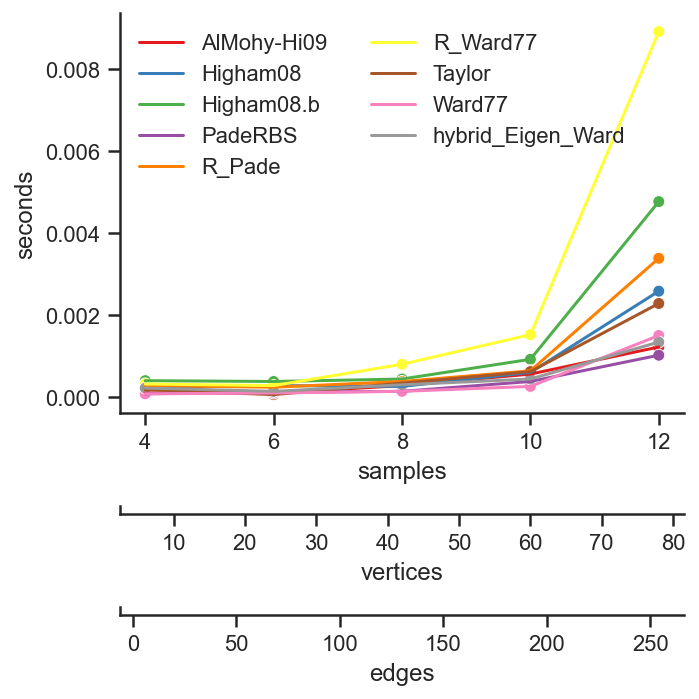

In [29]:
plot_df = (expm_tests_all_methods.groupby(['val', 'vertices', 'edges', 'method'])
 .agg('mean') 
 .reset_index()
 .rename(columns={'time_spent_exp': 'seconds', 'val': str(units[0])})
)
fig, axes = runtime_plot(plot_df, [str(units[0]), 'vertices', 'edges'], 'seconds', 'method')
axes[0].legend(ncol=2, loc="upper left", framealpha=0)
#axes[0].set_yscale('log')
plt.savefig(f'figures/expm_tests_all_methods_{str(label[0])}.pdf')   

## Functions for timing

Comparing phasetyper, matrixdist ptdalgorithms.

PhaseTyper uses base::solve() for inversion

Reviewer two says matrixdist::matrix_inverse() is much faster for sparse matrices. However, only some phase-type distributions fit coxian or erlang forms and our tool is a general one. For the phase-type distributions used as mdoels here matrixdist is not faster:



In [67]:
%%R 

cdf_vals <- seq(from = 0.1, to = 10, by = 0.1)

expectation_fun <- function(i, val) {
    graph <- construction_fun(val)
    M <- graph_as_matrix(graph)
    phasetyper_time <- NA
    ptdalgorithms_time <- NA
    if (val <= expectation_max_construction_values_for_matrix) {
        Y <- PH(M$SIM, M$IPV)            
        start <- proc.time()[3]
        PhaseTypeR::mean(Y)
        end <- proc.time()[3]
        phasetyper_time <- end - start
    }
    start <- proc.time()[3]
    ptdalgorithms::expectation(graph)
    end <- proc.time()[3]
    ptdalgorithms_time = end-start
    df <- as.data.frame(cbind(val=val, 
                              ptdalgorithms_time=ptdalgorithms_time, 
                              phasetyper_time=phasetyper_time,
                              vertices=vertices_length(graph), 
                              edges=number_of_edges(graph)))
    return(df)
}

moments100_fun <- function(i, val) {
    graph <- construction_fun(val)
    M <- graph_as_matrix(graph)
    phasetyper_time <- NA
    ptdalgorithms_time <- NA
    if (val <= moments100_max_construction_values_for_matrix) {
        Y <- PH(M$SIM, M$IPV)            
        rewards <- rep(1, length(M$IPV))
        start <- proc.time()[3]
        for (i in 1:100) {
           Y <- PhaseTypeR::reward_phase_type(Y, rewards)
           PhaseTypeR::mean(Y)
        }
        end <- proc.time()[3]
        phasetyper_time <- end - start                     
    }
    start <- proc.time()[3]
    rewards <- rep(1, length(rowSums(states(graph))))
    for (i in 1:100) {
       graph <- reward_transform(graph, rewards)
       expectation(graph)
    }
    end <- proc.time()[3]
    ptdalgorithms_time = end-start
    df <- as.data.frame(cbind(val=val, 
                              ptdalgorithms_time=ptdalgorithms_time, 
                              phasetyper_time=phasetyper_time,
                              vertices=vertices_length(graph), 
                              edges=number_of_edges(graph)))
    return(df)
}

cdf100_fun <- function(i, val) {
    graph <- construction_fun(val)
    x <- seq(from = 0.1, to = 10, by = 0.1)
    y <- ptdalgorithms::pph(x, graph)
    max_t <- approx(y, x, 0.99)$y
    cdf_samples <- seq((max_t-2)/100, max_t, (max_t-2)/100)
    
    graph <- construction_fun(val)
    phasetyper_time <- NA
    ptdalgorithms_time <- NA
    start <- proc.time()[3]
    ptdcdf <- ptdalgorithms::pph(cdf_samples, graph, 10000)
    stop <- proc.time()[3]
    ptdalgorithms_time <- stop - start
    if (val <= cdf100_max_construction_values_for_matrix) {
         M <- graph_as_matrix(graph)
        start <- proc.time()[3]
        Y <- PhaseTypeR::PH(M$SIM, M$IPV)
        PhaseTypeR::pPH(cdf_samples, Y)
        stop <- proc.time()[3]
        phasetyper_time <- stop - start
    }
    df <- as.data.frame(cbind(val=val, 
                              ptdalgorithms_time=ptdalgorithms_time, 
                              phasetyper_time=phasetyper_time,
                              vertices=vertices_length(graph), 
                              edges=number_of_edges(graph)))
    return(df) 
}

## Expectation

In [61]:
%%time
%%R -o expectation_df

expectation_df <- apply_grid(expectation_fun, 1:(niter), expectation_construction_values)

INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

CPU times: user 9min 41s, sys: 3min 14s, total: 12min 55s
Wall time: 11min 48s


In [62]:
expectation_df.to_hdf(f'benchmark_data/expectation_df_{str(label[0])}.hdf', 'df')

## 100 moments

In [33]:
%%time
%%R -o moments100_df

moments100_df <- apply_grid(moments100_fun, 1:niter, moments100_construction_values)

INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

CPU times: user 7h 3min 40s, sys: 28min 41s, total: 7h 32min 22s
Wall time: 2h 31min 50s


In [34]:
moments100_df.to_hdf(f'benchmark_data/moments100_df_{str(label[0])}.hdf', 'df')

## CDF 100 values

In [77]:
%%time
%%R -o cdf100_df

cdf100_df <- apply_grid(cdf100_fun, 1:niter, cdf100_construction_values)

CPU times: user 1h 12min 1s, sys: 3min 5s, total: 1h 15min 6s
Wall time: 40min 6s


In [78]:
cdf100_df.to_hdf(f'benchmark_data/cdf100_df_{str(label[0])}.hdf', 'df')

# Plots

## Coalescent

In [10]:
construction_df = pd.read_hdf(f'benchmark_data/construction_df_coalescent.hdf')

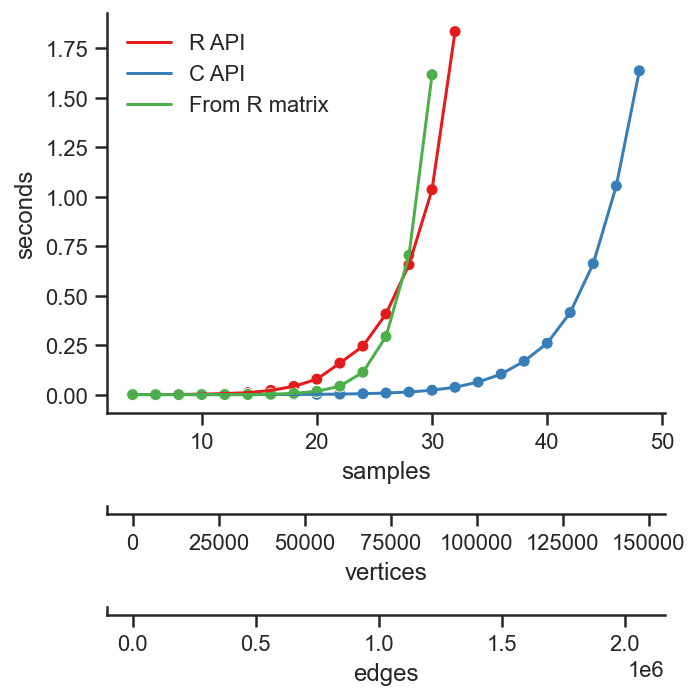

In [13]:
plot_df = (construction_df.groupby(['val', 'vertices', 'edges'])
 .agg('mean') 
 .reset_index()
 .rename(columns={'val': 'samples', 'time_c': 'C API', 'time_R': 'R API', 'time_from_matrix': 'From R matrix'})
 .melt(id_vars=['samples', 'vertices', 'edges'], value_name='seconds', var_name='API')
)
plot_df = plot_df.loc[plot_df.seconds < 2]
fig, axes = runtime_plot(plot_df, ['samples', 'vertices', 'edges'], 'seconds', 'API', 
            legend_title=False)

plt.savefig(f'figures/construction_coalescent.pdf')

In [14]:
plot_df.groupby('API').samples.max()

API
C API            48.0
From R matrix    30.0
R API            32.0
Name: samples, dtype: float64

In [15]:
expectation_df = pd.read_hdf(f'benchmark_data/expectation_df_coalescent.hdf')

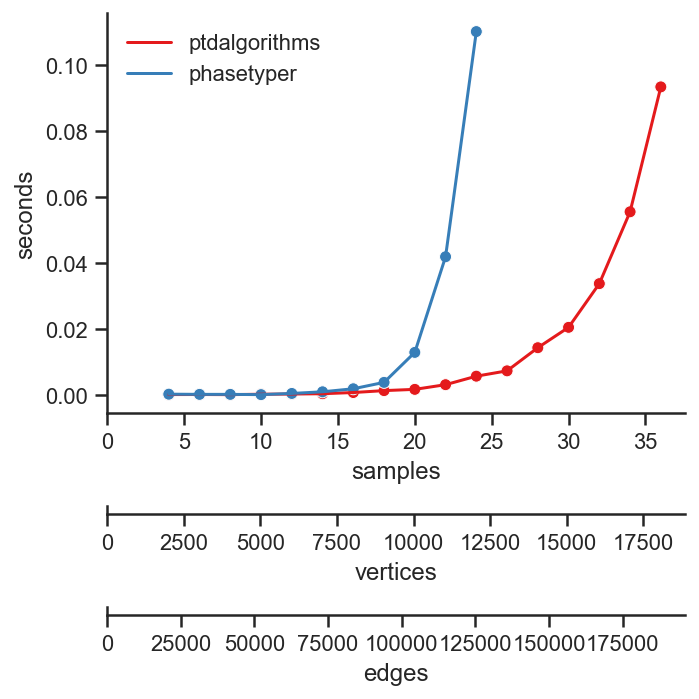

In [16]:
plot_df = (expectation_df.groupby(['val', 'vertices', 'edges'])
 .agg('mean') 
 .reset_index()
 .rename(columns={'val': 'samples',
                  'ptdalgorithms_time': 'ptdalgorithms', 
                  'phasetyper_time': 'phasetyper',
                  'matrixdist_time': 'matrixdist::moment()',
                  'matrixdist_inverse_time': 'matrixdist::inverse_matrix()',
                  'solve_time': 'base::solve()'
                 })
 .melt(id_vars=['samples', 'vertices', 'edges'], 
       value_name='seconds', var_name='Method')
)
plot_df = plot_df.loc[plot_df.seconds < 0.15]
fig, axes = runtime_plot(plot_df, ['samples', 'vertices', 'edges'],
                         'seconds', 'Method', legend_title=False)
for ax in axes:
    ax.set_xlim(left=0)
plt.savefig(f'figures/expectation_coalescent.pdf')

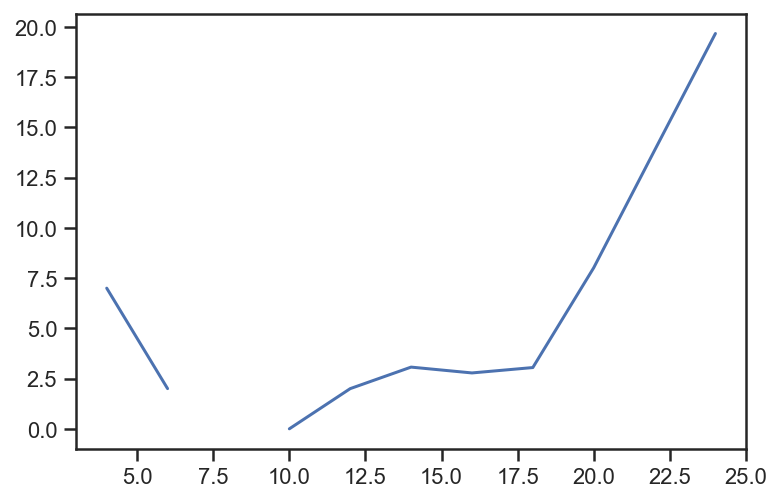

In [54]:
df = pd.pivot(plot_df, index='samples', columns='Method', values=['seconds']).reset_index()
plt.plot(df.samples, df.seconds.phasetyper / df.seconds.ptdalgorithms)

In [174]:
plot_df.groupby('Method').samples.max()

Method
phasetyper       24.0
ptdalgorithms    36.0
Name: samples, dtype: float64

In [55]:
moments100_df = pd.read_hdf(f'benchmark_data/moments100_df_coalescent.hdf')

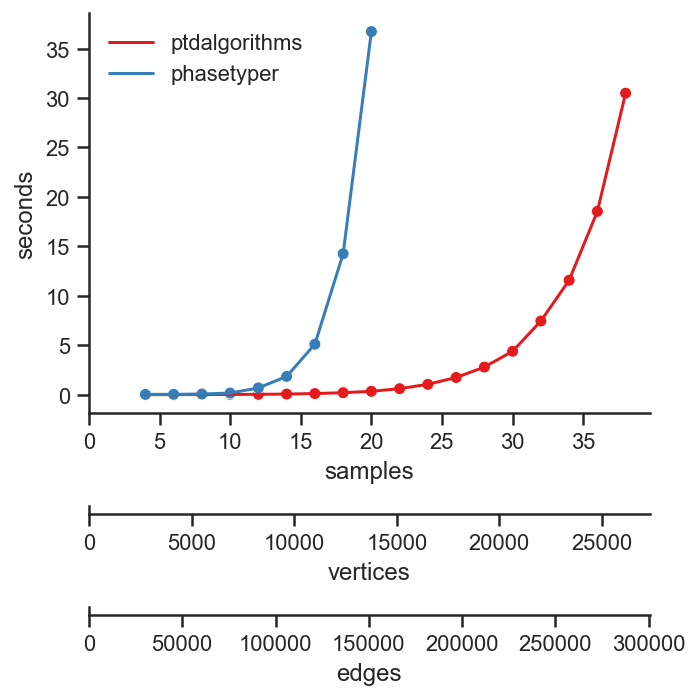

In [56]:
plot_df = (moments100_df.groupby(['val', 'vertices', 'edges'])
 .agg('mean') 
 .reset_index()
 .rename(columns={'val': 'samples',
                  'ptdalgorithms_time': 'ptdalgorithms', 
                  'phasetyper_time': 'phasetyper',
                  'matrixdist_time': 'matrixdist::moment()',
                  'matrixdist_inverse_time': 'matrixdist::inverse_matrix()',
                  'solve_time': 'base::solve()'
                 })
 .melt(id_vars=['samples', 'vertices', 'edges'], 
       value_name='seconds', var_name='Method')
)
plot_df = plot_df.loc[plot_df.seconds < 40]
fig, axes = runtime_plot(plot_df, ['samples', 'vertices', 'edges'],
                         'seconds', 'Method', legend_title=False)
for ax in axes:
    ax.set_xlim(left=0)
plt.savefig(f'figures/moments_100_coalescent.pdf')

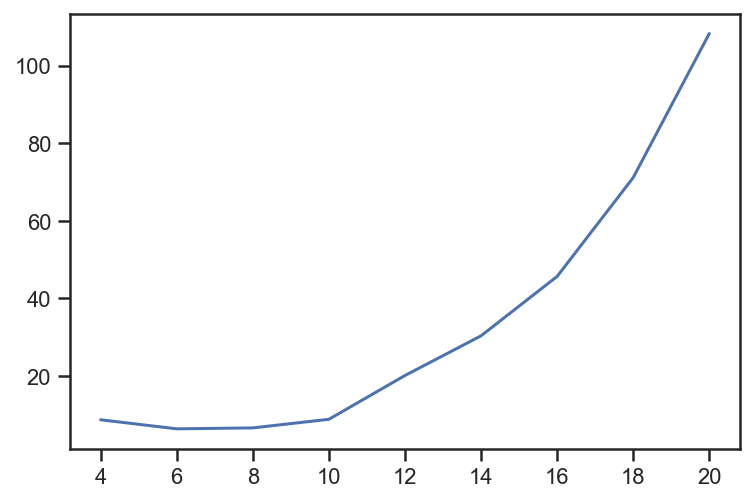

In [57]:
df = pd.pivot(plot_df, index='samples', columns='Method', values=['seconds']).reset_index()
plt.plot(df.samples, df.seconds.phasetyper / df.seconds.ptdalgorithms)

In [177]:
plot_df.groupby('Method').samples.max()

Method
phasetyper       20.0
ptdalgorithms    38.0
Name: samples, dtype: float64

In [60]:
cdf100_df = pd.read_hdf(f'benchmark_data/cdf100_df_coalescent.hdf')

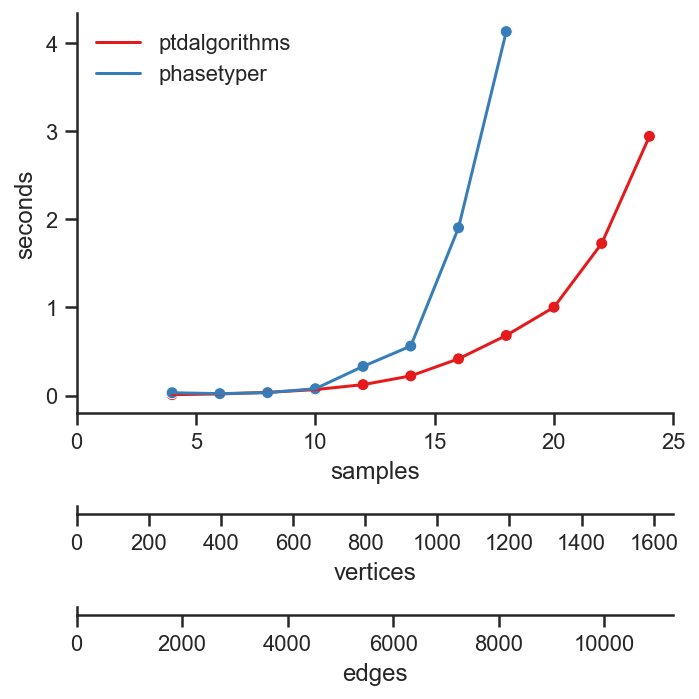

In [61]:
plot_df = (cdf100_df.groupby(['val', 'vertices', 'edges'])
 .agg('mean') 
 .reset_index()
 .rename(columns={'val': 'samples',
                  'ptdalgorithms_time': 'ptdalgorithms', 
                  'phasetyper_time': 'phasetyper'})
 .melt(id_vars=['samples', 'vertices', 'edges'], 
       value_name='seconds', var_name='Method')
)
plot_df = plot_df.loc[plot_df.seconds < 5]
fig, axes = runtime_plot(plot_df, ['samples', 'vertices', 'edges'],
                         'seconds', 'Method', legend_title=False)
for ax in axes:
    ax.set_xlim(left=0)
plt.savefig(f'figures/cdf100_coalescent.pdf')

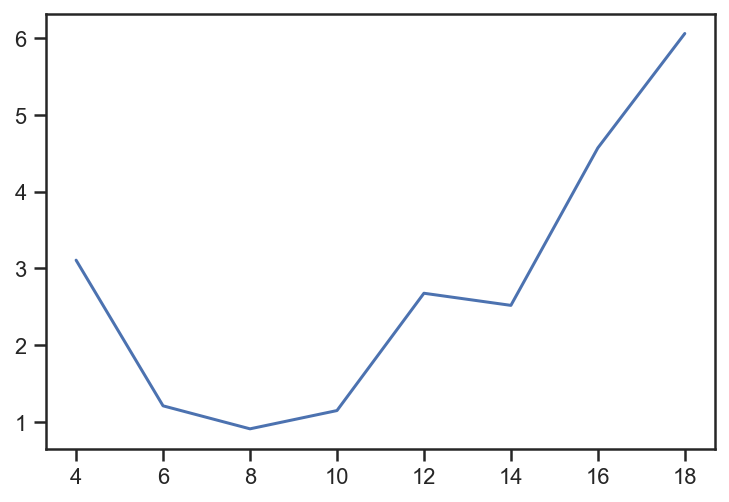

In [62]:
df = pd.pivot(plot_df, index='samples', columns='Method', values=['seconds']).reset_index()
plt.plot(df.samples, df.seconds.phasetyper / df.seconds.ptdalgorithms)

In [180]:
plot_df.groupby('Method').samples.max()

Method
phasetyper       18.0
ptdalgorithms    30.0
Name: samples, dtype: float64

## Rabbits

In [63]:
construction_df = pd.read_hdf(f'benchmark_data/construction_df_rabbits.hdf')

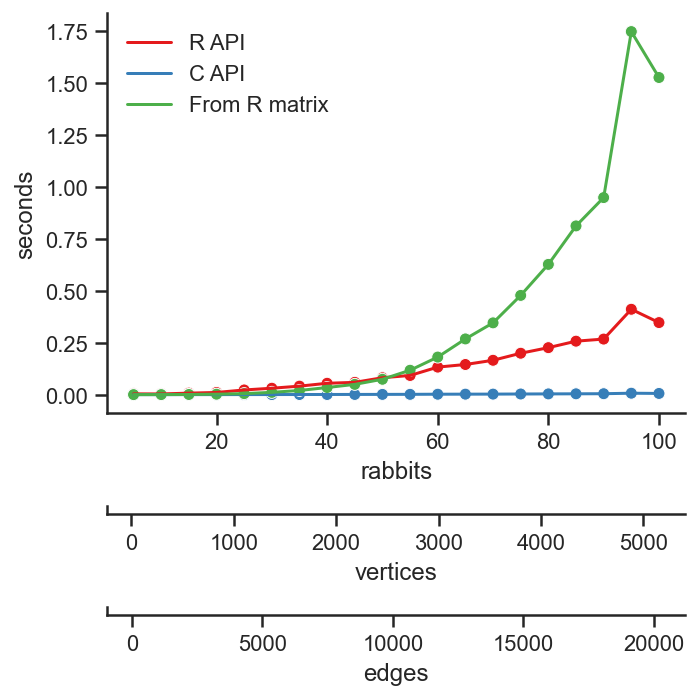

In [64]:
plot_df = (construction_df.groupby(['val', 'vertices', 'edges'])
 .agg('mean') 
 .reset_index()
 .rename(columns={'val': 'rabbits', 'time_c': 'C API', 'time_R': 'R API', 'time_from_matrix': 'From R matrix'})
 .melt(id_vars=['rabbits', 'vertices', 'edges'], value_name='seconds', var_name='API')
)
plot_df = plot_df.loc[plot_df.seconds < 2]
fig, axes = runtime_plot(plot_df, ['rabbits', 'vertices', 'edges'], 'seconds', 'API', 
            legend_title=False)

plt.savefig(f'figures/construction_rabbits.pdf')

In [65]:
plot_df.groupby('API').rabbits.max()

API
C API            100.0
From R matrix    100.0
R API            100.0
Name: rabbits, dtype: float64

In [66]:
expectation_df = pd.read_hdf(f'benchmark_data/expectation_df_rabbits.hdf')

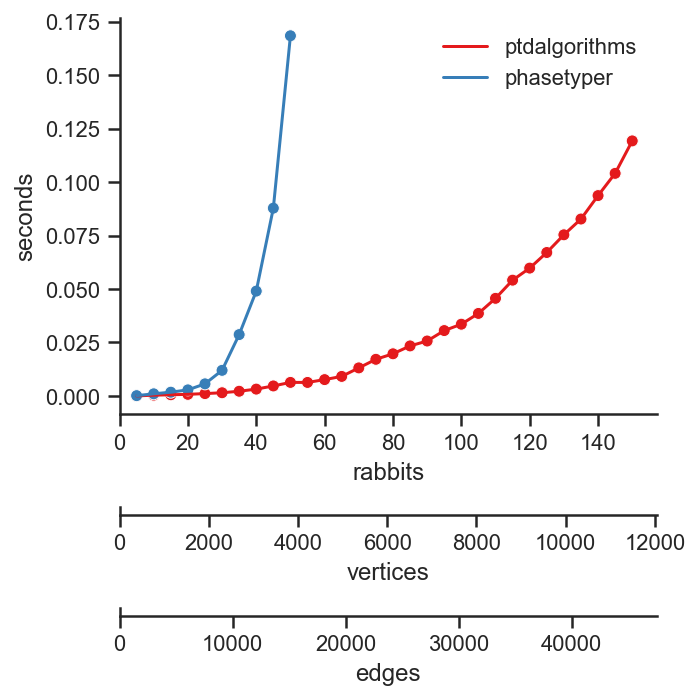

In [67]:
plot_df = (expectation_df.groupby(['val', 'vertices', 'edges'])
 .agg('mean') 
 .reset_index()
 .rename(columns={'val': 'rabbits',
                  'ptdalgorithms_time': 'ptdalgorithms', 
                  'phasetyper_time': 'phasetyper',
                  'matrixdist_time': 'matrixdist::moment()',
                  'matrixdist_inverse_time': 'matrixdist::inverse_matrix()',
                  'solve_time': 'base::solve()'
                 })
 .melt(id_vars=['rabbits', 'vertices', 'edges'], 
       value_name='seconds', var_name='Method')
)
plot_df = plot_df.loc[plot_df.seconds < 0.2]
fig, axes = runtime_plot(plot_df, ['rabbits', 'vertices', 'edges'],
                         'seconds', 'Method', legend_title=False)
for ax in axes:
    ax.set_xlim(left=0)
plt.savefig(f'figures/expectation_rabbits.pdf')

In [186]:
plot_df.groupby('Method').rabbits.max()

Method
phasetyper        50.0
ptdalgorithms    150.0
Name: rabbits, dtype: float64

In [187]:
moments100_df = pd.read_hdf(f'benchmark_data/moments100_df_rabbits.hdf')

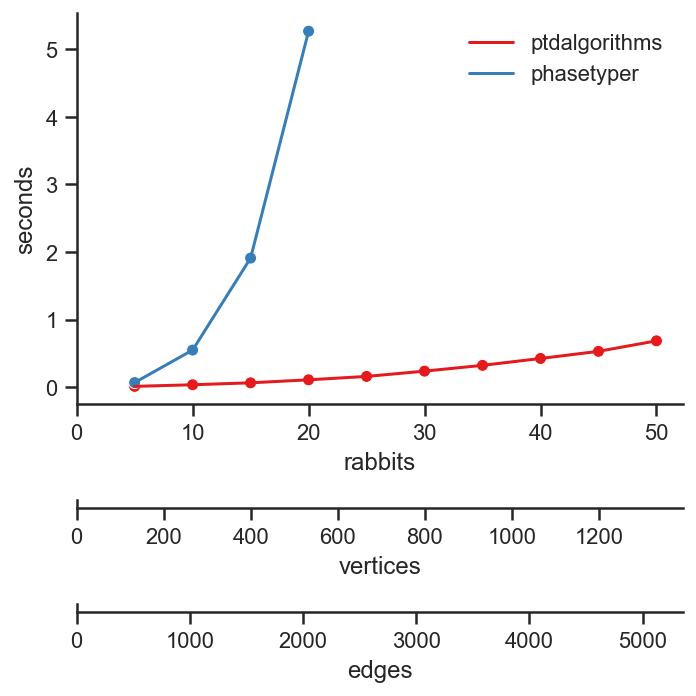

In [188]:
plot_df = (moments100_df.groupby(['val', 'vertices', 'edges'])
 .agg('mean') 
 .reset_index()
 .rename(columns={'val': 'rabbits',
                  'ptdalgorithms_time': 'ptdalgorithms', 
                  'phasetyper_time': 'phasetyper',
                  'matrixdist_time': 'matrixdist::moment()',
                  'matrixdist_inverse_time': 'matrixdist::inverse_matrix()',
                  'solve_time': 'base::solve()'
                 })
 .melt(id_vars=['rabbits', 'vertices', 'edges'], 
       value_name='seconds', var_name='Method')
)
plot_df = plot_df.loc[plot_df.seconds < 6]
fig, axes = runtime_plot(plot_df, ['rabbits', 'vertices', 'edges'],
                         'seconds', 'Method', legend_title=False)
for ax in axes:
    ax.set_xlim(left=0)
plt.savefig(f'figures/moments_100_rabbits.pdf')

In [189]:
plot_df.groupby('Method').rabbits.max()

Method
phasetyper       20.0
ptdalgorithms    50.0
Name: rabbits, dtype: float64

In [74]:
cdf100_df = pd.read_hdf(f'benchmark_data/cdf100_df_rabbits.hdf')

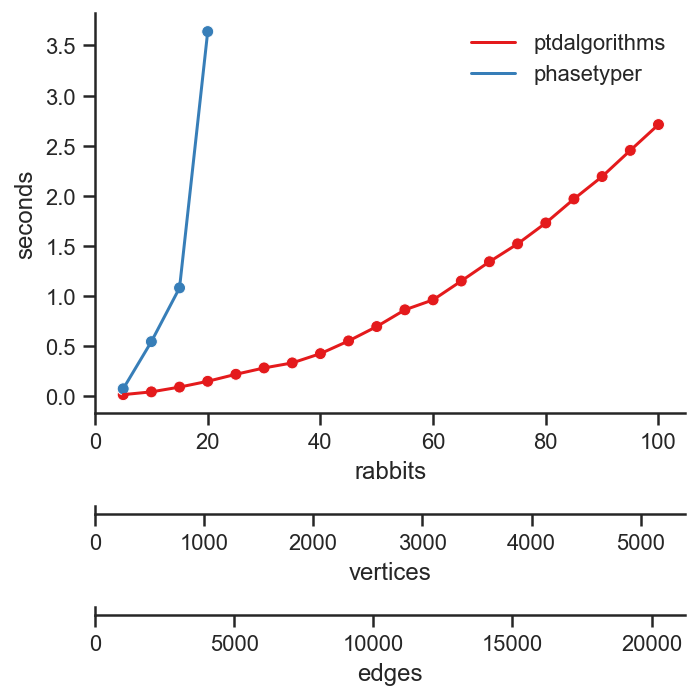

In [75]:
plot_df = (cdf100_df.groupby(['val', 'vertices', 'edges'])
 .agg('mean') 
 .reset_index()
 .rename(columns={'val': 'rabbits',
                  'ptdalgorithms_time': 'ptdalgorithms', 
                  'phasetyper_time': 'phasetyper'})
 .melt(id_vars=['rabbits', 'vertices', 'edges'], 
       value_name='seconds', var_name='Method')
)
plot_df = plot_df.loc[plot_df.seconds < 5]
fig, axes = runtime_plot(plot_df, ['rabbits', 'vertices', 'edges'],
                         'seconds', 'Method', legend_title=False)
for ax in axes:
    ax.set_xlim(left=0)
plt.savefig(f'figures/cdf100_rabbits.pdf')

In [192]:
plot_df.groupby('Method').rabbits.max()

Method
phasetyper        30.0
ptdalgorithms    100.0
Name: rabbits, dtype: float64

# OLD STUFF

# 100 marginal expecations (phasetyper, ptdalgorithms)

We agree that matrixdist::inverse_matrix is a bit faster than base:solve on the examples used. This means that phasetyper (which uses base solve) could gain some speed by using matrixdist::inverse_matrix.

We compare to phasetyper below  as it offers the same same functionality as ptdalgoritms.

# Distribution (CDF 100 vals)